In [30]:
# Data handling and processing
import pandas as pd
import numpy as np

# Solar position calculations
from pvlib import solarposition

# Display
import plotly.express as px
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.dates as mdates
import seaborn as sns


# Define the start and end dates, considering a whole year
start = f'2024-01-01 00:00:00'
end = f'2025-01-01 00:00:00'

# Generate a sequence of datetimes in 15 minutes intervals
times = pd.date_range(start, end, freq='15min')

# Calculate solar position for the daterange generated (coordinate for Peniche) 
df = solarposition.get_solarposition(times, latitude=39.34883424, longitude=-9.34298515)

# Remove nighttime
df = df[df['apparent_elevation'] > 0]

# Keep only the apparent_elevation and the azimuth
# Use df = pd.concat([df1, df2, etc]) and start = f'2024-{month:02d}-21 00:00:00' to generate a dataframe over loops
df = df.drop(columns=['apparent_zenith', 'zenith', 'elevation', 'equation_of_time'])

# It is easy to extract datetime information
df['month'] = df.index.month
df['day'] = df.index.day
df['time'] = df.index.time
df['dayofyear'] = df.index.dayofyear
df['date'] = pd.to_datetime(df.index.date)

# Formatting the time is a little trickier 
# For some reason, seaborn and matplotlib have issues with df['time']
# Hence, we just normalize the YYYY-MM-DD part of a datetime object
df['_datetime']=df.index.to_series().apply(lambda dt: dt.replace(year=1900, month=1, day=1)) 

# Convert from the North-bearing CW azimuth reference frame to the East-bearing CCW polar reference frame
df['theta'] = - 90 - df['azimuth']

# Calculate the shadow length
df['shadow_length'] = 1 / np.tan(df['apparent_elevation'] * np.pi/180)

# Calculate the cartesian coordinates of the shadow
df['x'] = df['shadow_length'] * np.cos( df['theta'] * np.pi/180 )
df['y'] = df['shadow_length'] * np.sin( df['theta'] * np.pi/180 )

# Save the data for inspection
display(df.to_excel('data/data.xlsx'))

# Inspect this data
df.info()
df.head()

None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17794 entries, 2024-01-01 08:00:00 to 2024-12-31 17:15:00
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   apparent_elevation  17794 non-null  float64       
 1   azimuth             17794 non-null  float64       
 2   month               17794 non-null  int32         
 3   day                 17794 non-null  int32         
 4   time                17794 non-null  object        
 5   dayofyear           17794 non-null  int32         
 6   date                17794 non-null  datetime64[ns]
 7   _datetime           17794 non-null  datetime64[ns]
 8   theta               17794 non-null  float64       
 9   shadow_length       17794 non-null  float64       
 10  x                   17794 non-null  float64       
 11  y                   17794 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int32(3), object(1)
memory usage:

apparent_elevation     azimuth  month  day      time  \
2024-01-01 08:00:00            0.166443  120.044816      1    1  08:00:00   
2024-01-01 08:15:00            2.381356  122.444439      1    1  08:15:00   
2024-01-01 08:30:00            4.693136  124.914396      1    1  08:30:00   
2024-01-01 08:45:00            6.985308  127.461857      1    1  08:45:00   
2024-01-01 09:00:00            9.218603  130.093667      1    1  09:00:00   

                     dayofyear       date           _datetime       theta  \
2024-01-01 08:00:00          1 2024-01-01 1900-01-01 08:00:00 -210.044816   
2024-01-01 08:15:00          1 2024-01-01 1900-01-01 08:15:00 -212.444439   
2024-01-01 08:30:00          1 2024-01-01 1900-01-01 08:30:00 -214.914396   
2024-01-01 08:45:00          1 2024-01-01 1900-01-01 08:45:00 -217.461857   
2024-01-01 09:00:00          1 2024-01-01 1900-01-01 09:00:00 -220.093667   

                     shadow_length           x           y  
2024-01-01 08:00:00     344.235560 -297.982022  172.350908  
2024-01-01 08:15:00      24.046296  -20.292960   12.900393  
2024-01-01 08:30:00      12.181105   -9.988605    6.971879  
2024-01-01 08:45:00       8.161648   -6.478377    4.964185  
2024-01-01 09:00:00       6.161510   -4.713510    3.968253

Now we can easily make a series of animations in plotly that help us visualize the dynamic behaviour of the the sun path and cast shadows over time.

In [31]:
fig = px.line(df, x='azimuth', y='apparent_elevation', animation_frame='dayofyear', title='Elevation versus Azimuth over 2024')
fig.update_layout(yaxis_range=[0,100], xaxis_range=[0, 360])
fig.write_html("html/azimuth vs elevation.html")
fig.show()

In [32]:
fig = px.line(df, x='x', y='y', animation_frame='dayofyear', title='Daily Shadow Position over 2024')
fig.update_layout(yaxis_range=[-10,10], xaxis_range=[-10, 10])
fig.write_html("html/shadow vs day.html")
fig.show()

In [33]:
fig = px.line(df.sort_values(by=['time', 'date']), x='x', y='y', animation_frame='time', title='Daily Shadow Position over 2024')
fig.update_layout(yaxis_range=[-5,5], xaxis_range=[-10, 10])
fig.write_html("html/shadow vs hour.html")
fig.show()

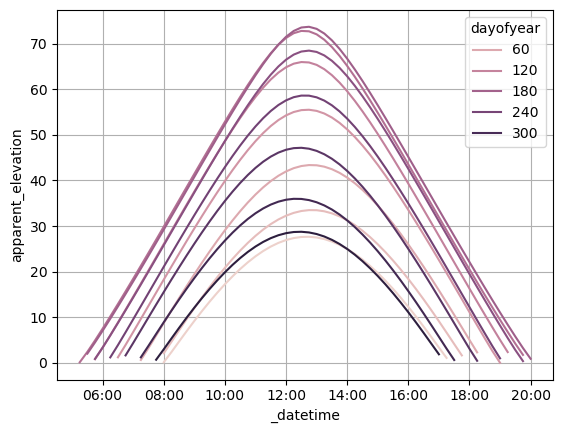

In [34]:
ax = sns.lineplot(df[df['day']==1], x='_datetime', y='apparent_elevation', hue='dayofyear')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.grid()
plt.show()

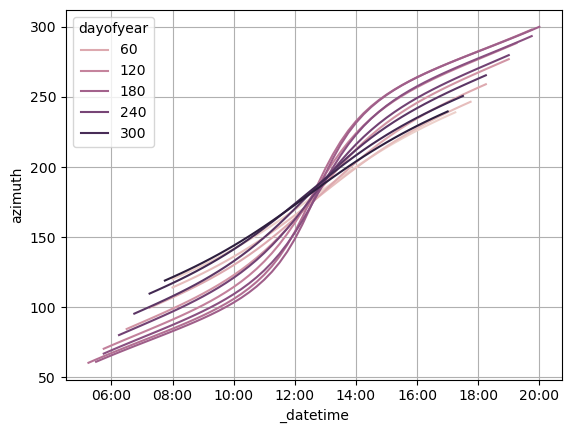

In [35]:
ax = sns.lineplot(df[df['day']==1], x='_datetime', y='azimuth', hue='dayofyear')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.grid()
plt.show()

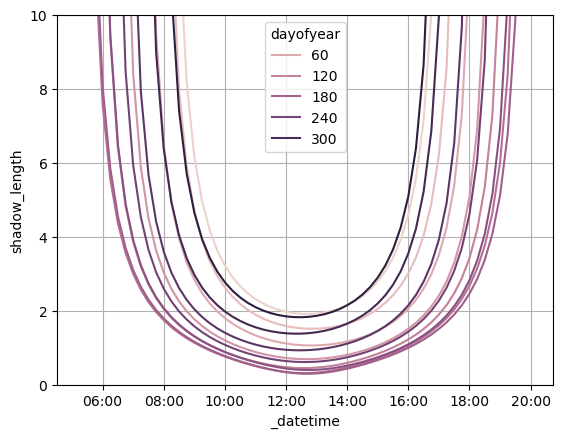

In [36]:
ax = sns.lineplot(df[df['day']==1], x='_datetime', y='shadow_length', hue='dayofyear')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(0, 10)
ax.grid()
plt.show()

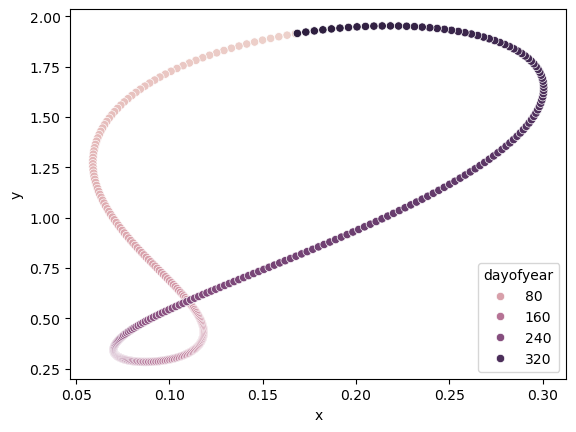

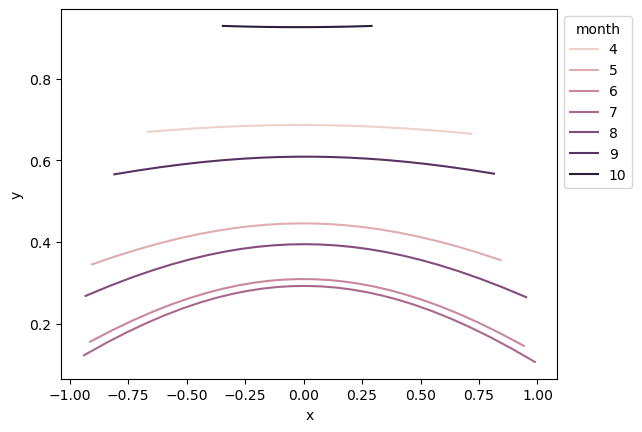

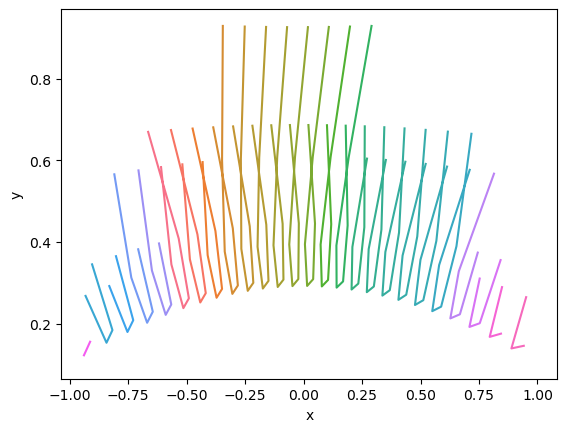

In [37]:
sns.scatterplot(df[df['_datetime'] == '1900-01-01 13:00:00'], x='x', y='y', hue='dayofyear')
plt.show()

ax = sns.lineplot(df[(df['day'] == 1) & (df['shadow_length']<1)], x='x', y='y', sort=False, hue='month')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

ax = sns.lineplot(df[(df['day'] == 1) & (df['shadow_length']<1)], x='x', y='y', sort=False, hue='_datetime')
ax.get_legend().remove()
plt.show()

In [41]:
fig = px.density_contour(df, x="x", y="y")
fig.update_traces(contours_coloring="fill", contours_showlabels = True)
fig.update_layout(yaxis_range=[-20,20], xaxis_range=[-30, 30])
fig.show()

In [44]:
fig = px.density_heatmap(
    df[(np.abs(df['x'])<4) & (np.abs(df['y'])<4)], 
    x="x", y="y", marginal_x="histogram", marginal_y="histogram")
fig.show()

We can use the EZDXF library to save the shadow path to an AutoCAD file.

In [47]:
import ezdxf

def generate_dxf(path: str, points: np.ndarray, close: bool) -> None:
    '''Example usage: 
        generate_dxf('line.dxf', [(0, 0), (10, 0), (10, 10)], True)
    '''
    # create a new DXF R2010 document
    doc = ezdxf.new("R2010")

    # add new entities to the modelspace
    msp = doc.modelspace()

    # add a LINE entity
    msp.add_lwpolyline(points, close=close)
    
    # save the DXF document
    doc.saveas(path)

    return None

# As an example, get the shadow path along the course of of day of the year
data = df[(df['date']=='2024-06-21') & (df['shadow_length']<10)]
points = data[['x', 'y']].to_numpy()
generate_dxf('data/shading.dxf', np.vstack([points, np.zeros(2)]), True)